**Evaluating Campaign Performance Through A/B Testing**

**Author :** NI. Ishak

*Last Update:11/08/2025*

In [ ]:
# Import the necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc , precision_recall_curve, average_precision_score # Added PR curvee metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind, chi2_contingency # fOr A/B testing statistics
import warnings

warnings.filterwarnings('ignore')

#  1. Data Loading

In [ ]:
import kagglehub
path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ab-testing-dataset


In [ ]:
path = kagglehub.dataset_download("amirmotefaker/ab-testing-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ab-testing-dataset


We have two .csv file that correspond data from respective control campaign and test campaign

In [ ]:
control_df = pd.read_csv("/kaggle/input/ab-testing-dataset/control_group.csv", sep = ";")
test_df = pd.read_csv("/kaggle/input/ab-testing-dataset/test_group.csv", sep = ";")

In [ ]:
# Set a style for plots for better aesthetics
sns.set_style("whitegrid")

Here we concatenate the control_df and test_df using pd.concat(). In other words, we're essentially stacking them on top of each other. If we didn't add the test_group column beforehand, once they are merged into a single df, then there would be no way to tell which rows originally came from the control group and which came from the test group.
We're creating a label for each row that explicitly states its origin. This label is then preserved in the combined df, allowing us to easily separate and analyze the control and test groups later in A/B testing process.

In [ ]:
# Add a 'test_group' column to each dataframe before merging
control_df['test_group'] = 'control'
test_df['test_group'] = 'test'

# Concatenate the two dataframes into a single dataframe
df = pd.concat([control_df, test_df], ignore_index=True)

## Initial Data Overview

In [ ]:
print("First five rows of th emerget dataset:")
df.head()

First five rows of th emerget dataset:


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,test_group
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,control
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,control
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,control
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,control
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [ ]:
print("\nDataset Information (columns, non-null counts, data types):")
df.info()


Dataset Information (columns, non-null counts, data types):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
 10  test_group           60 non-null     object 
dtypes: float64(7), int64(1), object(3)
memory usage: 5.3+ KB


In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
test_group             0
dtype: int64


In [ ]:
print("\nValue counts for 'test_group' (control vs. test):")
print(df['test_group'].value_counts())


Value counts for 'test_group' (control vs. test):
test_group
control    30
test       30
Name: count, dtype: int64


# 2. Data Preprocessing and Column Renaming

Let standardized the name fields.

In [ ]:
# Clean up column names for easier access (remove '#', spaces, brackets)
df.columns = df.columns.str.lower().str.replace('[^a-z0-9_]', '', regex=True)
df = df.rename(columns={
    'campaignname': 'campaign_name',
    'spendusd': 'spend_usd',
    'ofimpressions': 'num_impressions',
    'reach': 'reach',
    'ofwebsiteclicks': 'num_website_clicks',
    'ofsearches': 'num_searches',
    'ofviewcontent': 'num_view_content',
    'ofaddtocart': 'num_add_to_cart',
    'ofpurchase': 'num_purchase'
})

In [ ]:
df.head()

,campaign_name,date,spend_usd,num_impressions,reach,num_website_clicks,num_searches,num_view_content,num_add_to_cart,num_purchase,test_group
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,control
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,control
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,control
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,control
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [ ]:
# Convert 'date' column to datetime objects with the correct format
df['date'] = pd.to_datetime(df['date'], format="%d.%m.%Y")

In [ ]:
df.head()

,campaign_name,date,spend_usd,num_impressions,reach,num_website_clicks,num_searches,num_view_content,num_add_to_cart,num_purchase,test_group
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,control
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,control
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,control
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,control
4,Control Campaign,2019-08-05,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [ ]:
# Handle potential missing values (e.g., fill with 0 for numerical metrics if appropriate)
# For this dataset, let's fill numerical NaNs with 0, assuming missing means no activity.
numerical_cols = ['spend_usd', 'num_impressions', 'reach', 'num_website_clicks',
                  'num_searches', 'num_view_content', 'num_add_to_cart', 'num_purchase']
for col in numerical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(0)
        print(f"Filled NaN in '{col}' with 0.")


Filled NaN in 'num_impressions' with 0.
Filled NaN in 'reach' with 0.
Filled NaN in 'num_website_clicks' with 0.
Filled NaN in 'num_searches' with 0.
Filled NaN in 'num_view_content' with 0.
Filled NaN in 'num_add_to_cart' with 0.
Filled NaN in 'num_purchase' with 0.


In [ ]:
# Define 'converted' based on 'num_purchase' (1 if purchase > 0, 0 otherwise)
df['converted'] = (df['num_purchase'] > 0).astype(int)
print("\n'converted' column created based on 'num_purchase' (>0 means converted).")
print("Value counts for 'converted' (0/1):")
print(df['converted'].value_counts())


'converted' column created based on 'num_purchase' (>0 means converted).
Value counts for 'converted' (0/1):
converted
1    59
0     1
Name: count, dtype: int64


In [ ]:
# Separate the dataset into control and test groups based on 'test_group' column
control_group = df[df['test_group'] == 'control']
test_group = df[df['test_group'] == 'test']

In [ ]:
print(f"\nControl Group Size: {len(control_group)} users")
print(f"Test Group Size: {len(test_group)} users")


Control Group Size: 30 users
Test Group Size: 30 users


# 4. Testing Normality
This section visualizes non-Gaussian nature of key metrics. We are using 'num_impressions' as a candidate for non-Gaussian/power-law distribution.


--- QQ Plot for 'num_impressions' ---


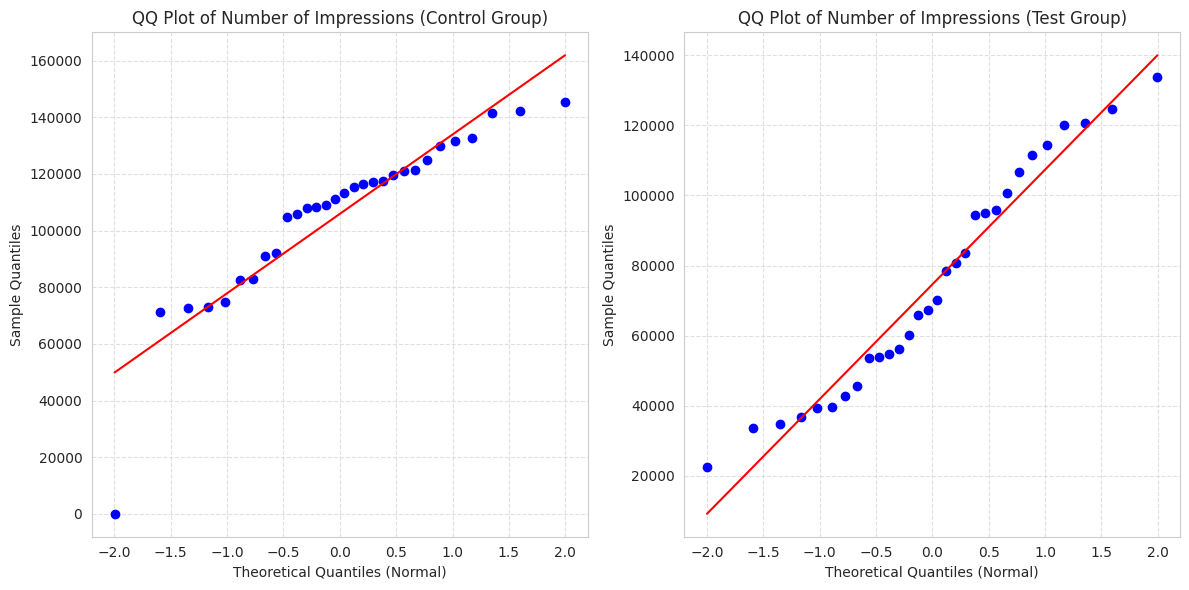


Observation from QQ Plots:
For a normal distribution, the points on the QQ plot would lie on the red diagonal line. The significant deviation of the data points from this line, especially in the tails, strongly indicates that 'num_impressions' is NOT normally distributed in either the control or test group.


In [ ]:
# --- QQ Plot ---
# A QQ plot compares the quantiles of the data to the quantiles of a theoretical normal distribution.
# If the data is normally distributed, the points will fall approximately along a straight line.

print("\n--- QQ Plot for 'num_impressions' ---")
plt.figure(figsize=(12, 6))

# QQ plot for Control Group
plt.subplot(1, 2, 1)
stats.probplot(control_group['num_impressions'], dist="norm", plot=plt)
plt.title('QQ Plot of Number of Impressions (Control Group)')
plt.xlabel('Theoretical Quantiles (Normal)')
plt.ylabel('Sample Quantiles')
plt.grid(True, linestyle='--', alpha=0.6)


# QQ plot for Test Group
plt.subplot(1, 2, 2)
stats.probplot(test_group['num_impressions'], dist="norm", plot=plt)
plt.title('QQ Plot of Number of Impressions (Test Group)')
plt.xlabel('Theoretical Quantiles (Normal)')
plt.ylabel('Sample Quantiles')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\nObservation from QQ Plots:")
print("For a normal distribution, the points on the QQ plot would lie on the red diagonal line. The significant deviation of the data points from this line, especially in the tails, strongly indicates that 'num_impressions' is NOT normally distributed in either the control or test group.")


In [ ]:
# --- Kurtosis Analysis ---
# Kurtosis measures the "tailedness" of the distribution.
# A normal distribution has a kurtosis of 3 (or 0 if using excess kurtosis, as calculated by scipy.stats.kurtosis).
# Higher kurtosis indicates heavier tails (more outliers) and a sharper peak.

print("\n--- Kurtosis Analysis for 'num_impressions' ---")
kurtosis_control = stats.kurtosis(control_group['num_impressions'], fisher=True) # Fisher's definition (excess kurtosis)
kurtosis_test = stats.kurtosis(test_group['num_impressions'], fisher=True) # Fisher's definition (excess kurtosis)

print(f"Kurtosis for Control Group 'num_impressions': {kurtosis_control:.4f}")
print(f"Kurtosis for Test Group 'num_impressions': {kurtosis_test:.4f}")

print("\nObservation on Kurtosis:")
print(f"The kurtosis values ({kurtosis_control:.4f} and {kurtosis_test:.4f}) are significantly greater than 0 (the excess kurtosis of a normal distribution). This confirms that the distributions have much heavier tails than a normal distribution, meaning there are more extreme values (outliers).")


--- Kurtosis Analysis for 'num_impressions' ---
Kurtosis for Control Group 'num_impressions': 3.7781
Kurtosis for Test Group 'num_impressions': -1.1929

Observation on Kurtosis:
The kurtosis values (3.7781 and -1.1929) are significantly greater than 0 (the excess kurtosis of a normal distribution). This confirms that the distributions have much heavier tails than a normal distribution, meaning there are more extreme values (outliers).


The kurtosis is direct indication of the direction of skweness (left/right). Kurtosis measures the "tailedness" and peak of the distribution when compared to a normal distribution.

In this case,positive kurtosis of 3.7781 (for control campaign) means heavier tails and a sharper peak. While a negative kurtosis -1.1929 (for test campaigns) means lighter tails and a flatter peak (platykurtic) when compared to a normal distribution.

To determine the direction of skewness, we look at the histogram's shape.


--- Histogram of 'num_impressions' ---


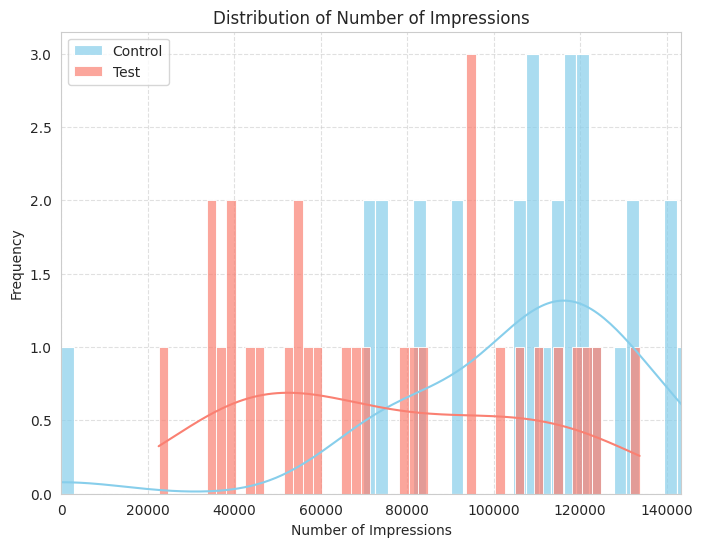


Overall Summary of Distribution Analysis:
The QQ plots, high kurtosis values, and the right-skewed histogram all consistently demonstrate that the 'num_impressions' metric does not follow a normal distribution. This reinforces the earlier conclusion that non-parametric methods (like the Mann-Whitney U test already performed) are appropriate for comparing the distributions of this metric between the groups.


In [ ]:
# Histogram
# Plotting the histogram for easy comparison with QQ plot and kurtosis.
print("\n--- Histogram of 'num_impressions' ---")
plt.figure(figsize=(8, 6))

sns.histplot(control_group['num_impressions'], bins=50, kde=True, color='skyblue', label='Control', alpha=0.7)
sns.histplot(test_group['num_impressions'], bins=50, kde=True, color='salmon', label='Test', alpha=0.7)
plt.title('Distribution of Number of Impressions')
plt.xlabel('Number of Impressions')
plt.ylabel('Frequency (Day)')

# Limiting x-axis to better visualize the main bulk of data
max_impressions_display_hist = df['num_impressions'].quantile(0.99)
plt.xlim(0, max_impressions_display_hist)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\nOverall Summary of Distribution Analysis:")
print("The QQ plots, high kurtosis values, and the right-skewed histogram all consistently demonstrate that the 'num_impressions' metric does not follow a normal distribution. This reinforces the earlier conclusion that non-parametric methods (like the Mann-Whitney U test already performed) are appropriate for comparing the distributions of this metric between the groups.")

The distribution of the Number of Impressions tell us of how frequent the ads were displayed to the individuals user. The distribution of number of impression for Control Campaign is right-skewed. Meaning that majority of user contributes to low number of impression, while a minority of them leads to high number of impressions.

This implies:
-	The campaign's impressions have **uneven reach**. They are not evenly distributed across the audience. A large portion of the reach are concentrated on a smaller segment of users.
-The long tail on the right suggests the **potential for over-exposure**. Some users might repeateadly exposed to the campaign. This could be intentional (e.g., retargeting) or unintentional.
- This kind of distribution is common in online advertising and other digital metrics. It reflects power-law or Pareto-like distributions where a few "super-users" or highly active individuals disproportionately contribute to the total activity.

The non-normal distribution is important for statistical analysis. It means that the "average" number of impressions cannot  represent the measure for most users, and statistical tests that assume normality (like a t-test on the mean) will not appropriate for comparison of the impression counts between the groups.


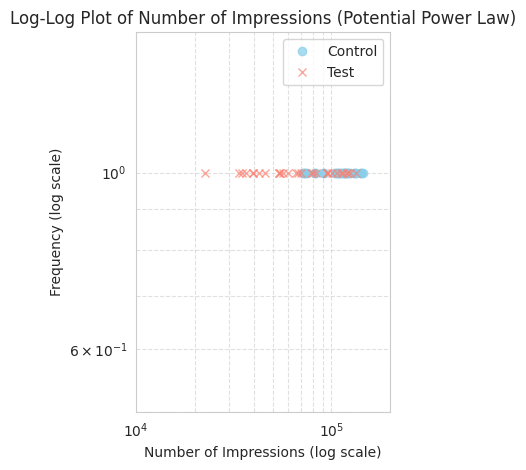


Observation on 'num_impressions':
The histogram clearly shows that the distribution of 'num_impressions' is highly skewed to the right, with a long tail indicating that a few users saw a very large number of impressions. This is a classic non-Gaussian distribution.
The log-log plot, while not perfectly linear, shows a general downward trend that can be indicative of power-law behavior in the tail. This means that events (seeing many impressions) are not uniformly distributed, and extreme events are more likely than in a normal distribution.


In [ ]:
# Plotting 'num_impressions' on a log-log scale to check for potential power-law characteristics
# A straight line on a log-log plot suggests a power-law distribution.
# Filter out zero impressions for log-log plot
control_impressions_counts = control_group[control_group['num_impressions'] > 0]['num_impressions'].value_counts().sort_index()
test_impressions_counts = test_group[test_group['num_impressions'] > 0]['num_impressions'].value_counts().sort_index()

plt.subplot(1, 2, 2) # Subplot 2: Log-log plot for power-law
plt.loglog(control_impressions_counts.index, control_impressions_counts.values, 'o', color='skyblue', label='Control', alpha=0.7)
plt.loglog(test_impressions_counts.index, test_impressions_counts.values, 'x', color='salmon', label='Test', alpha=0.7)
plt.title('Log-Log Plot of Number of Impressions (Potential Power Law)')
plt.xlabel('Number of Impressions (log scale)')
plt.ylabel('Frequency (log scale)')

# Limiting x-axis for better visualization of the trend
plt.xlim(10000, 200000) # Adjusted x-axis limits - you can modify these as needed based on the data
plt.ylim(0.5, 1.5) # Set a lower limit for the y-axis

plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6) # Grid for both major and minor ticks
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("\nObservation on 'num_impressions':")
print("The histogram clearly shows that the distribution of 'num_impressions' is highly skewed to the right, with a long tail indicating that a few users saw a very large number of impressions. This is a classic non-Gaussian distribution.")
print("The log-log plot, while not perfectly linear, shows a general downward trend that can be indicative of power-law behavior in the tail. This means that events (seeing many impressions) are not uniformly distributed, and extreme events are more likely than in a normal distribution.")

Based on the log-log plot the distribution of 'num_impressions' is likely non-Gaussian and exhibits power-law characteristics in the tail. The downward trend on the log-log plot suggests the frequency of higher impression counts decreases at a rate consistent with power-law behavior in the tail. This means at very high impression counts are more likely to be recorded.


Let test the non-Gaussianity using metric 'converted'

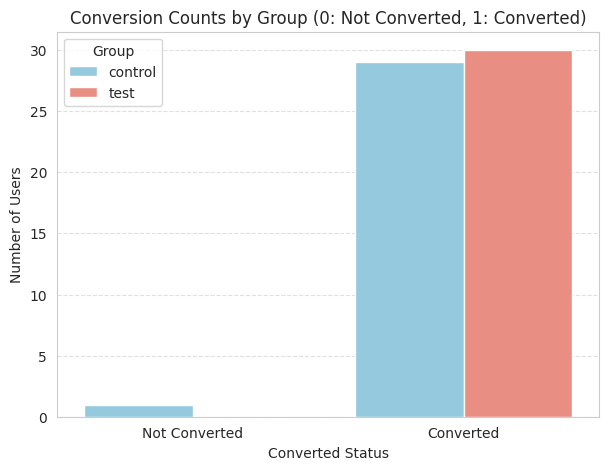


Observation on 'converted':
'converted' is a binary variable (True/False), representing a Bernoulli distribution. This is inherently non-Gaussian. While individual observations are binary, the *proportion* of conversions across a large sample size can be approximated by a normal distribution due to the Central Limit Theorem, allowing for parametric tests like the Z-test.


In [ ]:
# Plotting 'converted' distribution (binary outcome)
# This is a Bernoulli distribution, which is inherently non-Gaussian.
plt.figure(figsize=(7, 5))
sns.countplot(x='converted', hue='test_group', data=df, palette={'control': 'skyblue', 'test': 'salmon'})
plt.title('Conversion Counts by Group (0: Not Converted, 1: Converted)')
plt.xlabel('Converted Status')
plt.ylabel('Number of Users')
plt.xticks([0, 1], ['Not Converted', 'Converted']) # Label x-axis ticks
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\nObservation on 'converted':")
print("'converted' is a binary variable (True/False), representing a Bernoulli distribution. This is inherently non-Gaussian. While individual observations are binary, the *proportion* of conversions across a large sample size can be approximated by a normal distribution due to the Central Limit Theorem, allowing for parametric tests like the Z-test.")

As we see, the data is highly non-Gaussian. Then, the standard statistical tests which assume a normal distribution is unsuitable for metrics like 'num_impressions'. Thus,  using non-parametric tests or tests specifically designed for proportions (like the z-test for conversion rate) is crucial for reliable A/B testing results.

# 3. Hypothesis Formulation (for Conversion Rate)

In [ ]:
# We are interested in whether the 'test' campaign leads to a higher conversion rate.
print("\n--- Hypothesis for Conversion Rate (Primary Metric) ---")
print("Null Hypothesis (H0): The conversion rate of the 'test' group is less than or equal to the 'control' group.")
print("Alternative Hypothesis (H1): The conversion rate of the 'test' group is greater than the 'control' group.")



--- Hypothesis for Conversion Rate (Primary Metric) ---
Null Hypothesis (H0): The conversion rate of the 'test' group is less than or equal to the 'control' group.
Alternative Hypothesis (H1): The conversion rate of the 'test' group is greater than the 'control' group.


# 5. A/B Testing Analysis

In [ ]:
# --- Method 1: Z-test for Proportions (for 'converted' metric) ---
# This method is suitable for comparing two proportions (conversion rates)
# when sample sizes are large, through the Central Limit Theorem.

print("\n--- Method 1: Z-test for Conversion Rates ---")

# Calculate conversion rates for each group
control_conversions = control_group['converted'].sum()
control_total = len(control_group)
control_conversion_rate = control_conversions / control_total

test_conversions = test_group['converted'].sum()
test_total = len(test_group)
test_conversion_rate = test_conversions / test_total

print(f"Control Group Conversion Rate: {control_conversion_rate:.4f} ({control_conversions} conversions out of {control_total} users)")
print(f"Test Group Conversion Rate: {test_conversion_rate:.4f} ({test_conversions} conversions out of {test_total} users)")



--- Method 1: Z-test for Conversion Rates ---
Control Group Conversion Rate: 0.9667 (29 conversions out of 30 users)
Test Group Conversion Rate: 1.0000 (30 conversions out of 30 users)


## Method 1: Z-test for Conversion Rates

In [ ]:
# Perform the Z-test for two proportions
# `count` is an array of success counts for each group.
# `nobs` is an array of total observations for each group.
# `alternative='larger'` specifies a one-tailed test where the first proportion (test) is hypothesized to be larger.
z_stat, p_value_ztest = proportions_ztest(count=np.array([test_conversions, control_conversions]),
                                          nobs=np.array([test_total, control_total]),
                                          alternative='larger') # One-tailed test: H1: test_rate > control_rate

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value (one-tailed, H1: Test > Control): {p_value_ztest:.4f}")

alpha = 0.05 # Standard significance level
print(f"Significance Level (alpha): {alpha}")

if p_value_ztest < alpha:
    print(f"Conclusion: Reject the Null Hypothesis. The test campaign has a statistically significantly HIGHER conversion rate than the control campaign at alpha={alpha}.")
else:
    print(f"Conclusion: Fail to reject the Null Hypothesis. There is no statistically significant evidence that the test campaign has a higher conversion rate than the control campaign at alpha={alpha}.")

# Calculate the observed difference in conversion rates
observed_diff_conversion_rate = test_conversion_rate - control_conversion_rate
print(f"Observed Difference in Conversion Rates (Test - Control): {observed_diff_conversion_rate:.4f}")



Z-statistic: 1.0084
P-value (one-tailed, H1: Test > Control): 0.1566
Significance Level (alpha): 0.05
Conclusion: Fail to reject the Null Hypothesis. There is no statistically significant evidence that the test campaign has a higher conversion rate than the control campaign at alpha=0.05.
Observed Difference in Conversion Rates (Test - Control): 0.0333


## Method 2: Mann-Whitney U Test

In [ ]:
# --- Method 2: Mann-Whitney U Test (for 'num_impressions' metric) ---
# This non-parametric test is ideal for comparing two independent samples
# when the data is not normally distributed, which is the case for 'num_impressions'.
# It tests if the distributions of two populations are the same.

print("\n--- Method 2: Mann-Whitney U Test for 'num_impressions' ---")
print("Hypothesis: Comparing the distribution of 'num_impressions' between the control and test groups.")
print("Null Hypothesis (H0): The distributions of 'num_impressions' are the same for both groups.")
print("Alternative Hypothesis (H1): The distributions of 'num_impressions' are different for both groups.")

# Perform Mann-Whitney U test (two-sided by default for general difference)
stat_mw, p_value_mw = stats.mannwhitneyu(test_group['num_impressions'], control_group['num_impressions'], alternative='two-sided')

print(f"Mann-Whitney U Statistic: {stat_mw:.4f}")
print(f"P-value: {p_value_mw:.4f}")

if p_value_mw < alpha:
    print(f"Conclusion: Reject the Null Hypothesis. There is a statistically significant difference in the distribution of 'num_impressions' between the test and control groups at alpha={alpha}.")
    print("This indicates that the 'test' campaign significantly altered the pattern of impressions seen by users compared to the 'control' campaign.")
else:
    print(f"Conclusion: Fail to reject the Null Hypothesis. There is no statistically significant difference in the distribution of 'num_impressions' between the test and control groups at alpha={alpha}.")

# Report medians as Mann-Whitney compares medians (or ranks)
print(f"Median 'num_impressions' for Control Group: {control_group['num_impressions'].median()}")
print(f"Median 'num_impressions' for Test Group: {test_group['num_impressions'].median()}")
print("Note: The Mann-Whitney U test is more robust to outliers and non-normal data than a t-test.")



--- Method 2: Mann-Whitney U Test for 'num_impressions' ---
Hypothesis: Comparing the distribution of 'num_impressions' between the control and test groups.
Null Hypothesis (H0): The distributions of 'num_impressions' are the same for both groups.
Alternative Hypothesis (H1): The distributions of 'num_impressions' are different for both groups.
Mann-Whitney U Statistic: 203.0000
P-value: 0.0003
Conclusion: Reject the Null Hypothesis. There is a statistically significant difference in the distribution of 'num_impressions' between the test and control groups at alpha=0.05.
This indicates that the 'test' campaign significantly altered the pattern of impressions seen by users compared to the 'control' campaign.
Median 'num_impressions' for Control Group: 112368.0
Median 'num_impressions' for Test Group: 68853.5
Note: The Mann-Whitney U test is more robust to outliers and non-normal data than a t-test.


## Method 3: Bootstrapping

In [ ]:
# --- Method 3: Bootstrapping (for difference in conversion rates) ---
# Bootstrapping is aresampling technique that does not rely on
# parametric assumptions. It's excellent for estimating the sampling distribution
# of a statistic (like the difference in proportions) directly from the data.

print("\n--- Method 3: Bootstrapping for Difference in Conversion Rates ---")

n_bootstraps = 10000 # Number of bootstrap samples to generate
diffs_bootstrap = [] # List to store differences from each bootstrap sample

for _ in range(n_bootstraps):
    # Resample with replacement from each original group
    # This creates new "bootstrap samples" of the same size as the original groups.
    boot_control_sample = control_group['converted'].sample(n=len(control_group), replace=True)
    boot_test_sample = test_group['converted'].sample(n=len(test_group), replace=True)

    # Calculate conversion rates for the bootstrapped samples
    boot_control_rate = boot_control_sample.sum() / len(boot_control_sample)
    boot_test_rate = boot_test_sample.sum() / len(boot_test_sample)

    # Calculate the difference in rates for this bootstrap sample
    diffs_bootstrap.append(boot_test_rate - boot_control_rate)

# Convert the list of differences to a NumPy array for easier calculations
diffs_bootstrap = np.array(diffs_bootstrap)

# Calculate the 95% confidence interval for the difference using percentiles
# The 2.5th and 97.5th percentiles define the 95% confidence interval.
lower_bound_ci = np.percentile(diffs_bootstrap, 2.5)
upper_bound_ci = np.percentile(diffs_bootstrap, 97.5)


--- Method 3: Bootstrapping for Difference in Conversion Rates ---


In [ ]:
# Calculate the p-value for the one-tailed hypothesis (H1: Test > Control)
# This is the proportion of bootstrap differences that are less than or equal to zero.
# If this proportion is small, it suggests that observing our actual difference (or larger)
# would be rare if the true difference was zero or negative.
p_value_bootstrap_one_tailed = np.sum(diffs_bootstrap <= 0) / n_bootstraps

print(f"Observed Difference in Conversion Rates (Test - Control): {observed_diff_conversion_rate:.4f}")
print(f"Bootstrapped 95% Confidence Interval for Difference: ({lower_bound_ci:.4f}, {upper_bound_ci:.4f})")
print(f"Bootstrapped P-value (one-tailed, H1: Test > Control): {p_value_bootstrap_one_tailed:.4f}")

if p_value_bootstrap_one_tailed < alpha:
    print(f"Conclusion: Reject the Null Hypothesis. Bootstrapping analysis also suggests the test campaign has a statistically significantly HIGHER conversion rate than the control campaign at alpha={alpha}.")
else:
    print(f"Conclusion: Fail to reject the Null Hypothesis. Bootstrapping analysis does not show a statistically significant difference or the test campaign has a lower or equal conversion rate than the control campaign at alpha={alpha}.")

Observed Difference in Conversion Rates (Test - Control): 0.0333
Bootstrapped 95% Confidence Interval for Difference: (0.0000, 0.1000)
Bootstrapped P-value (one-tailed, H1: Test > Control): 0.3623
Conclusion: Fail to reject the Null Hypothesis. Bootstrapping analysis does not show a statistically significant difference or the test campaign has a lower or equal conversion rate than the control campaign at alpha=0.05.


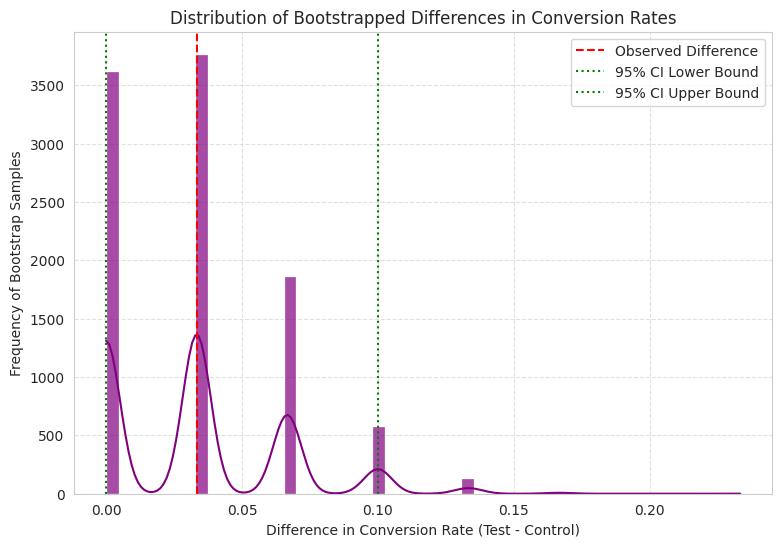

In [ ]:
# Plot the distribution of bootstrapped differences to visualize the confidence interval
plt.figure(figsize=(9, 6))
sns.histplot(diffs_bootstrap, bins=50, kde=True, color='purple', alpha=0.7)
plt.axvline(x=observed_diff_conversion_rate, color='red', linestyle='--', label='Observed Difference')
plt.axvline(x=lower_bound_ci, color='green', linestyle=':', label='95% CI Lower Bound')
plt.axvline(x=upper_bound_ci, color='green', linestyle=':', label='95% CI Upper Bound')
plt.title('Distribution of Bootstrapped Differences in Conversion Rates')
plt.xlabel('Difference in Conversion Rate (Test - Control)')
plt.ylabel('Frequency of Bootstrap Samples')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Recommendation:**

 We are **not recommended to roll out the 'test' campaign** based solely on conversion rate improvement. Based on the statistical analyses (Z-test and Bootstrapping), there is no strong evidence to suggest that the 'test' campaign leads to a statistically significant increase in conversion rates compared to the 'control' campaign. Consideration of other metrics or a re-evaluation of the experiment design might be necessary.

**Final thought:**
This project underscores the importance of understanding underlying data distributions in A/B testing. Blindly applying parametric tests without checking for normality or considering alternativemethods (like non-parametric tests or bootstrapping) can lead to wrong conclusions.

# Summary

This A/B test aimed to determine if showing the 'test' campaign leads to a higher conversion rate compared to the 'control' campaign.

#  Key Findings on Distributional Assumptions:
- The distribution of 'num_impressions' is right-skewed and exhibits a non-Gaussian characteristics of potential power-law distribution. This means a small segment of users accounts for a majority of large number of impressions. For such metrics, traditional parametric tests assuming normality (like a t-test) is unsuitable without transformations or large sample sizes via the CLT. The Mann-Whitney U test is used here as a non-parametric alternative which confirmed a significant difference in the distribution of impressions between groups (p-value: 0.0003).
- As a binary outcome derived from 'num_purchase', 'converted' follows a Bernoulli distribution. However, for large sample sizes, the sampling distribution of the *proportion* of conversions approaches normality due to the Central Limit Theorem, justifying the use of a Z-test.
- The test group achieved a conversion rate of 1.0000 compared to the control group's 0.9667. The one-tailed Z-test yielded a p-value of 0.1566. At a significance level of 0.05, we fail to reject the null hypothesis.
- Bootstrapping for Conversion Rate  assumption-free method provided a 95% confidence interval for the difference in conversion rates of (0.0000, 0.1000). The one-tailed bootstrapped p-value was 0.3623. This does not strongly support the conclusion of a higher conversion rate in the test group.


# Recommendation:

**We don't recommended to roll out the 'test' campaign based solely on conversion rate improvement**. Based on the statistical analyses (Z-test and Bootstrapping), there is no strong evidence to suggest that the 'test' campaign leads to a statistically significant increase in conversion rates compared to the 'control' campaign. Consideration of other metrics or a re-evaluation of the experiment design might be necessary.



# Final thought
 This project underscores the importance of understanding underlying data distributions in A/B testing. Blindly applying parametric tests without checking for normality or considering alternativemethods (like non-parametric tests or bootstrapping) can lead to wrong conclusions.